In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from scipy.stats import norm
from sklearn.linear_model import Lasso, LassoCV, lasso_path
from sklearn.model_selection import validation_curve, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from progressbar import ProgressBar

In [3]:
def asymmetric_loss(a, b):
    return lambda true, pred: np.array(
    [b*(np.exp(a*(y-y_hat))-a*(y-y_hat)-1) 
     for (y, y_hat) in zip(true, pred)])

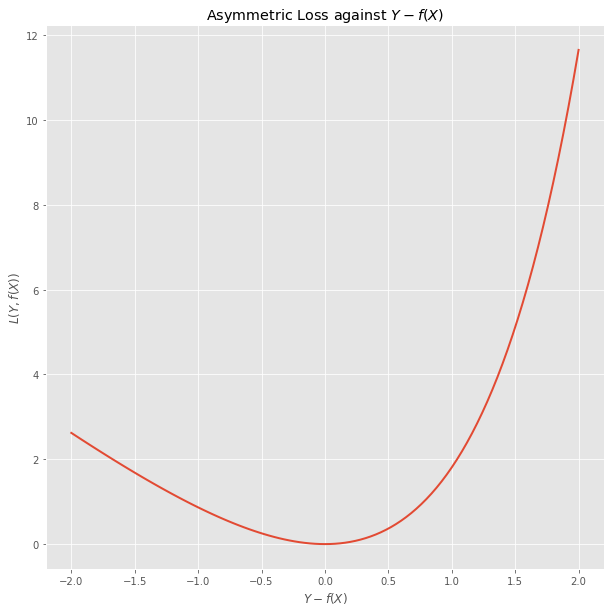

In [4]:
y = np.linspace(-2, 2, 101)
y_hat = np.array([0]*101)
loss = asymmetric_loss(1.1, 2)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(y,loss(y,y_hat), linewidth=2)
ax.set_title(r"Asymmetric Loss against $Y-f(X)$")
ax.set_xlabel(r"$Y-f(X)$")
_ = ax.set_ylabel(r"$L(Y,f(X))$")

In [8]:
# Set some parameters
beta = 0.5
b = 2
sigma = 2
a = 1

#Define the loss function, where z = y - yhat
def loss(z):
    return b*(np.exp(a*z)-a*z-1)

# Estimation functions
# Estimation using the conditional expectation of Y|X
def f_condexp(x):
    return beta*x

# TODO: Put your function in here.  
# You can reference a,b,sigma, and it will just pull them from
# the outside namespace
def f_yours(x):
    return beta*x+0.5*a*(sigma)**2
#Simulation to see how you do
reps = 1000

# Just generate the X variables normally.  We don't really care
x = norm.rvs(size=reps, loc=0, scale=1)

# Generate the Y variables from our normal model
y = norm.rvs(size=reps, loc=x*beta, scale=sigma)

# Calculate the fitted values for each method
yhat_condexp = np.apply_along_axis(f_condexp, 0, x)
yhat_yours = np.apply_along_axis(f_yours, 0, x)

# Compute the losses
condexp_losses = np.apply_along_axis(loss, 0, y-yhat_condexp)
your_losses = np.apply_along_axis(loss, 0, y-yhat_yours)

print("Average loss of the conditional expectation:",
      round(np.mean(condexp_losses),2))

print("Average loss of your method:", 
      round(np.mean(your_losses),2))


Average loss of the conditional expectation: 9.16
Average loss of your method: 3.61


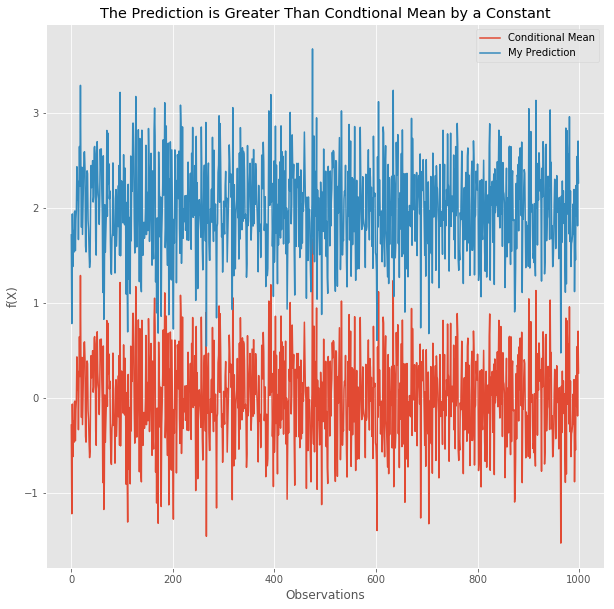

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(yhat_condexp, label="Conditional Mean")
ax.plot(yhat_yours, label="My Prediction")
ax.set_title("The Prediction is Greater Than Condtional Mean by a Constant")
ax.set_xlabel("Observations")
ax.set_ylabel("f(X)")
_ = ax.legend()

In [16]:
train.shape

(180, 98)

In [7]:
# load datasets
train = pd.read_csv("trends_train.csv")
test = pd.read_csv("trends_test.csv")
dates_train = train.values[:,0] 
dates_test = test.values[:,0]
X_train = np.asfarray(train.values[:,1:-1])
y_train = np.asfarray(train.values[:,-1])
X_test = np.asfarray(test.values[:,1:-1])
y_test = np.asfarray(test.values[:,-1])
words = train.columns[1:-1]

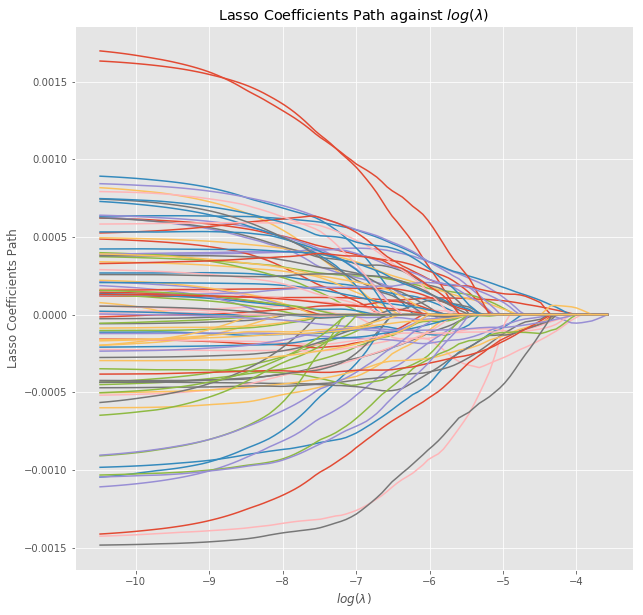

In [8]:
# make the lasso coefficients path
lambdas, coef_path, _ = lasso_path(X_train,y_train)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
_ = ax.plot(np.log(lambdas), coef_path.T)
ax.set_title(r"Lasso Coefficients Path against $log(\lambda)$")
ax.set_xlabel(r"$log(\lambda)$")
_ = ax.set_ylabel("Lasso Coefficients Path")

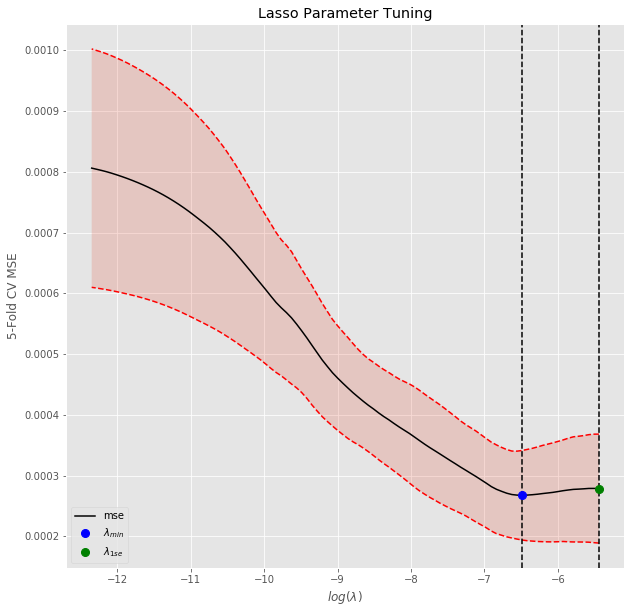

In [9]:
# preprocess data and fit model
cv_lasso = LassoCV(cv=5, normalize=0, max_iter=3000)
cv_clf = Pipeline([
    ('scl', StandardScaler()),
    ('lasso', cv_lasso),
])

# sklearn.linear_model.LassoCV has a wired normalizing method,
# it devides the columns of X by their l2 norm, 
# instead of standard deviation. It's not a natural thing to do,
# so I used sklearn.preprocessing.StandardScaler() instead.

cv_clf.fit(X_train, y_train)

# find lambda_min and mse path
lambda_range = cv_lasso.alphas_
mse_values = cv_lasso.mse_path_.mean(axis = 1)
sd_values = cv_lasso.mse_path_.std(axis = 1)
lambda_min = cv_lasso.alpha_
lambda_min_idx = np.where(lambda_range == lambda_min)[0][0]
one_se = sd_values[lambda_min_idx]
mse_min = mse_values[lambda_min_idx]

# find lambda_1se
i = lambda_min_idx
while i >= 0:
    if mse_values[i] >= mse_min + one_se:
        break
    i -= 1
if i < 0: i = 0
lambda_1se = lambda_range[i]
mse_1se = mse_values[i]

# make the plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(np.log(lambda_range), mse_values ,
        "-", color='black',label='mse')
ax.plot(np.log(lambda_range), mse_values + sd_values,"r--")
ax.plot(np.log(lambda_range), mse_values - sd_values,"r--")
ax.fill_between(np.log(lambda_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)
ax.axvline(np.log(lambda_min), ls='--', color='black')
ax.axvline(np.log(lambda_1se), ls='--', color='black')
ax.plot(np.log(lambda_min), mse_min, 'o', color='blue',
        markersize=8, label=r'$\lambda_{min}$')
ax.plot(np.log(lambda_1se), mse_1se, 'o', color='green',
        markersize=8, label=r'$\lambda_{1se}$')
ax.legend()
ax.set_title(r"Lasso Parameter Tuning")
ax.set_xlabel(r"$log(\lambda)$")
_ = ax.set_ylabel("5-Fold CV MSE")

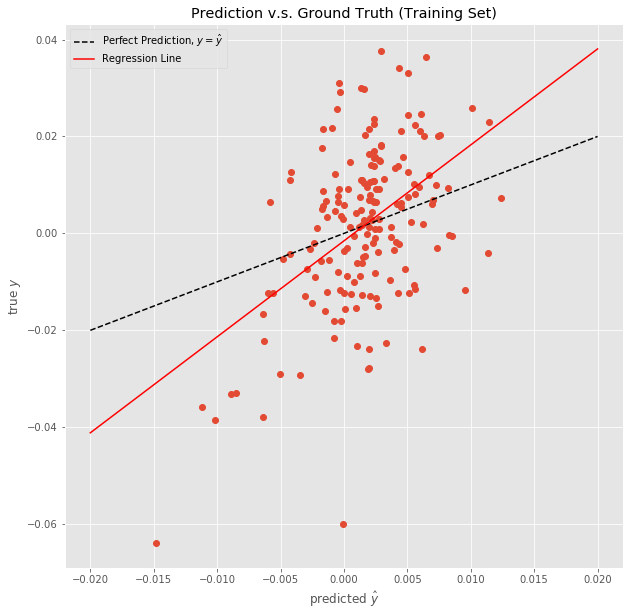

In [10]:
# refit the model using all the training set
clf_lambda_min = Pipeline([
    ('scl', StandardScaler()),
    ('lasso', Lasso(alpha=lambda_min, max_iter=2000))
])
clf_lambda_min.fit(X_train,y_train)

clf_lambda_1se = Pipeline([
    ('scl', StandardScaler()),
    ('lasso', Lasso(alpha=lambda_1se, max_iter=2000))
])
clf_lambda_1se.fit(X_train,y_train)

coef_min = clf_lambda_min.named_steps['lasso'].coef_
coef_1se = clf_lambda_1se.named_steps['lasso'].coef_
y_hat_train = clf_lambda_min.predict(X_train)

a, b = np.polyfit(y_hat_train, y_train, 1)
reg_line = np.linspace(-0.02, 0.02, 10)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(y_hat_train, y_train, 'o')
ax.plot([-0.02,0.02], [-0.02,0.02], '--', 
        color='black', label=r'Perfect Prediction, $y=\hat{y}$')
ax.plot(reg_line, reg_line*a + b, 'red', label='Regression Line')
ax.set_ylabel(r"true $y$")
ax.set_xlabel(r"predicted $\hat{y}$")
ax.set_title('Prediction v.s. Ground Truth (Training Set)')
_ = ax.legend()

In [11]:
print("Variables in lambda_min model: ", 
      [_ for _ in words[np.where(coef_min != 0)]], '\n')
print("Variables in lambda_1se model: ", 
      [_ for _ in words[np.where(coef_1se != 0)]])

Variables in lambda_min model:  ['growth', 'dow', 'invest', 'leverage', 'cash', 'nyse', 'sell', 'returns', 'present', 'rich', 'house', 'tourism', 'holiday', 'health', 'fine', 'marriage', 'restaurant'] 

Variables in lambda_1se model:  []


Cumulative log return using the model prediction: 0.972016182024
Cumulative log return of buy and hold: 0.283038084882


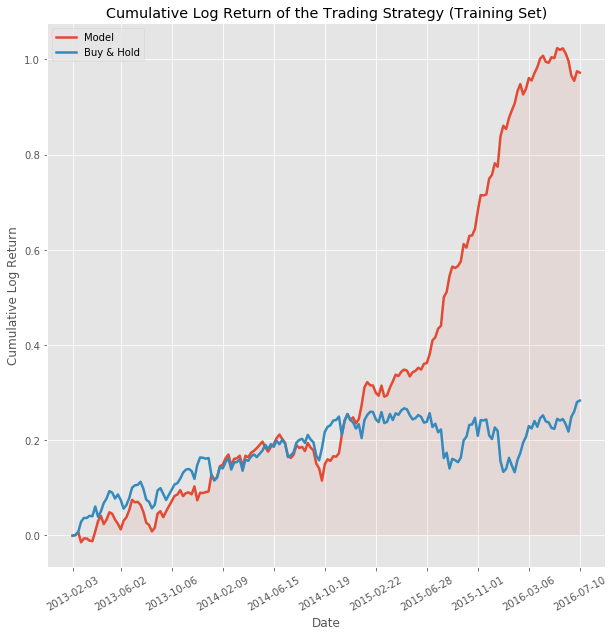

In [12]:
# The simple trading stategy on training set
cum_return = np.cumsum(np.sign(y_hat_train) * y_train)
buy_and_hold = np.cumsum(y_train)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(cum_return, linewidth=2.5, label='Model')
ax.plot(buy_and_hold, linewidth=2.5, label='Buy & Hold')
ax.fill_between(range(len(y_train)), cum_return,
                [0]*len(y_train), alpha = .08)
indices = np.arange(-1, len(y_train), 18); indices[0] = 0
ax.set_xticks(indices)
ax.set_xticklabels(dates_train[indices], rotation=30)
ax.set_title("Cumulative Log Return of the Trading Strategy (Training Set)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Log Return")
_ = ax.legend()

print("Cumulative log return using the model prediction:", cum_return[-1])
print("Cumulative log return of buy and hold:", buy_and_hold[-1])

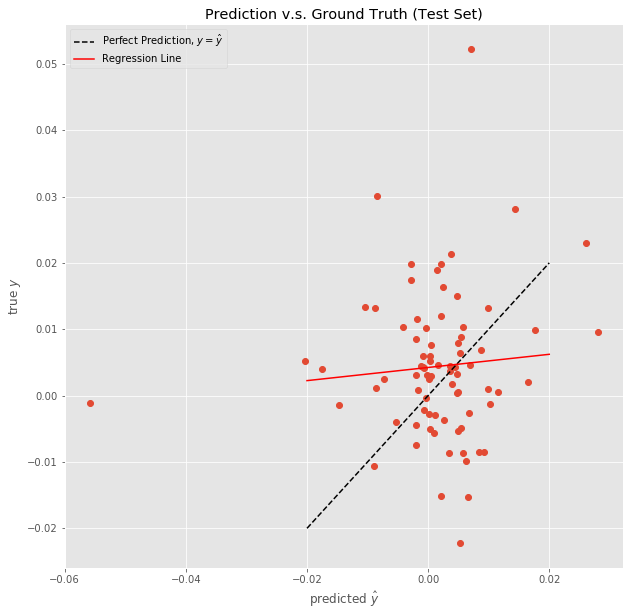

In [13]:
# make prediction on test set
y_hat_test = clf_lambda_min.predict(X_test)
a, b = np.polyfit(y_hat_test, y_test, 1)
reg_line = np.linspace(-0.02, 0.02, 10)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(y_hat_test, y_test, 'o')
ax.plot([-0.02,0.02], [-0.02,0.02], '--', 
        color='black', label=r'Perfect Prediction, $y=\hat{y}$')
ax.plot(reg_line, reg_line*a + b, 'red', label='Regression Line')
ax.set_ylabel(r"true $y$")
ax.set_xlabel(r"predicted $\hat{y}$")
ax.set_title('Prediction v.s. Ground Truth (Test Set)')
_ = ax.legend()

Cumulative log return using the model prediction: 0.0623050794901
Cumulative log return of buy and hold: 0.346153588946


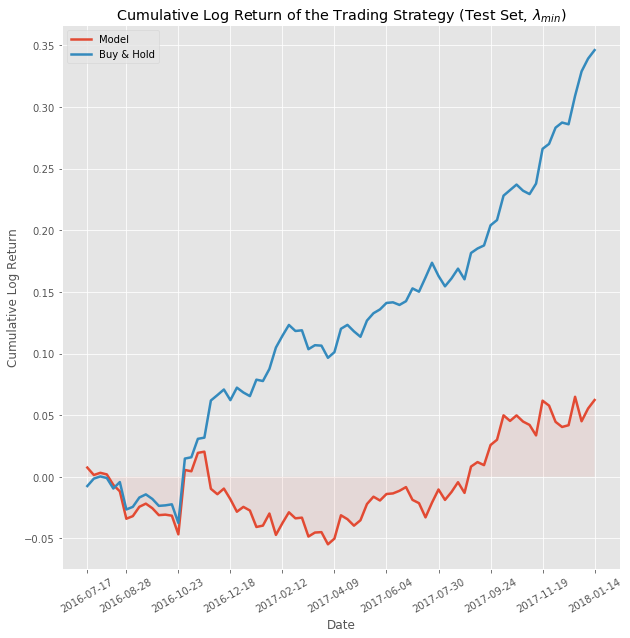

In [14]:
# The simple trading stategy on test set
cum_return = np.cumsum(np.sign(y_hat_test) * y_test)
buy_and_hold = np.cumsum(y_test)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(cum_return, linewidth=2.5, label='Model')
ax.plot(buy_and_hold, linewidth=2.5, label='Buy & Hold')
ax.fill_between(range(len(y_test)), cum_return,
                [0]*len(y_test), alpha = .08)
indices = np.arange(-2, 79, 8); indices[0] = 0
ax.set_xticks(indices)
ax.set_xticklabels(dates_test[indices], rotation=30)
ax.set_title(r"Cumulative Log Return of the Trading Strategy (Test Set, $\lambda_{min}$)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Log Return")
_ = ax.legend()

print("Cumulative log return using the model prediction:", cum_return[-1])
print("Cumulative log return of buy and hold:", buy_and_hold[-1])

Cumulative log return using the model prediction: 0.346153588946
Cumulative log return of buy and hold: 0.346153588946


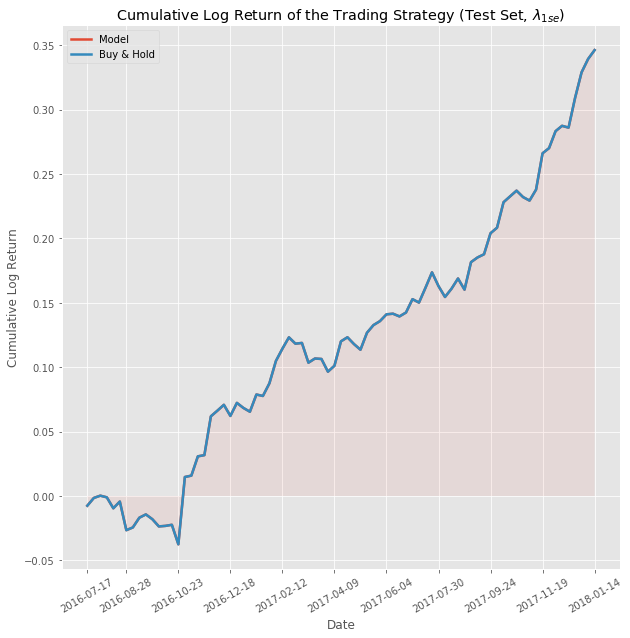

In [15]:
y_hat_test_1se = clf_lambda_1se.predict(X_test)

# The simple trading stategy on test set (using lambda_1se)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(np.cumsum(np.sign(y_hat_test_1se) * y_test), 
        linewidth=2.5, label='Model')
ax.plot(np.cumsum(y_test), linewidth=2.5, label='Buy & Hold')
ax.fill_between(range(len(y_test)),
                np.cumsum(np.sign(y_hat_test_1se) * y_test),
                [0]*len(y_test), alpha = .08)
indices = np.arange(-2, 79, 8); indices[0] = 0
ax.set_xticks(indices)
ax.set_xticklabels(dates_test[indices], rotation=30)
ax.set_title(r"Cumulative Log Return of the Trading Strategy (Test Set, $\lambda_{1se}$)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Log Return")
_ = ax.legend()

print("Cumulative log return using the model prediction:", 
      np.cumsum(np.sign(y_hat_test_1se) * y_test)[-1])
print("Cumulative log return of buy and hold:", buy_and_hold[-1])

We made no discovery at all